In [38]:
import sys
print(sys.executable)

C:\Users\ASUS\AppData\Local\Programs\Python\Python313\python.exe


In [39]:
import sys
!"{sys.executable}" -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install catboost
!{sys.executable} -m pip install shap

In [40]:
import pandas as pd
import numpy as np

In [41]:
import pandas as pd
file_path = r"C:\Users\ASUS\Downloads\Dementia Prediction Dataset.csv"
df = pd.read_csv(file_path, nrows=10000)
df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15564\3657887271.py:3: DtypeWarning: Columns (20,24,26,41,46,48,51,61,63,65,67,69,71,93,94,95,96,97,98,99,100,101,102,103,156,165,176,179,217,220,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,399,401,421,423,432,445,454,494,574,605,613,638,674,690,707,710,727,744,803,804,809,810,811,812,833,843,904,959,960,961,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, nrows=10000)


,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,NACC002909,186,F,3.0,1,23,2024,2,2,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,NACC003487,186,I,3.0,11,15,2023,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,NACC004687,186,I,3.0,11,14,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


Basic inspection of the dataset.

In [42]:
print("Rows, columns:", df.shape)
print(df.head())
df.info()

Rows, columns: (10000, 1024)
       NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  NACCVNUM  \
0  NACC002909      186      I      3.0       12        28     2022         1   
1  NACC002909      186      F      3.0        1        23     2024         2   
2  NACC003487      186      I      3.0       11        15     2023         1   
3  NACC004352      186      I      3.0       10         5     2021         1   
4  NACC004687      186      I      3.0       11        14     2022         1   

   NACCAVST  NACCNVST  ...  NPATGAM1  NPATGAM2  NPATGAM3  NPATGAM4  NPATGAM5  \
0         2         2  ...        -4        -4        -4        -4        -4   
1         2         2  ...        -4        -4        -4        -4        -4   
2         1         1  ...        -4        -4        -4        -4        -4   
3         1         1  ...        -4        -4        -4        -4        -4   
4         1         1  ...        -4        -4        -4        -4        -4   

   NPATGF

Defining the ID/VERSION/VISIT metadata columns to help with grouping and version handling since the dataset has three versions(version 1.2, 2 and 3). They will not be used as input features.

In [43]:
ID_COLS = [
    "NACCID",    # Subject identifier
    "NACCADC",   # Center ID (ADC)
]

VERSION_COLS = [
    "FORMVER",   # UDS form version: 1.2 / 2 / 3
    "PACKET",    # Packet type: I/F/T etc.
]

VISIT_COLS = [
    "VISITMO", "VISITDAY", "VISITYR",  # visit date
    "NACCVNUM",                         # visit number
    "NACCAVST", "NACCNVST",            # baseline visit flag
]

Next we are going to check if they exist in the dataset and print a warning if not.

In [44]:
for col in ID_COLS + VERSION_COLS + VISIT_COLS:
    if col not in df.columns:
        print(f"WARNING: {col} not found in df.columns")

Next we will create a single datetime column called VISITDATE for convenience instead of having three columns with VISITYR,VISITMO and VISITDAY.

In [45]:
df["VISITDATE"] = pd.to_datetime(
    dict(year=df["VISITYR"], month=df["VISITMO"], day=df["VISITDAY"]),
    errors="coerce"
)
df.head

<bound method NDFrame.head of           NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  \
0     NACC002909      186      I      3.0       12        28     2022   
1     NACC002909      186      F      3.0        1        23     2024   
2     NACC003487      186      I      3.0       11        15     2023   
3     NACC004352      186      I      3.0       10         5     2021   
4     NACC004687      186      I      3.0       11        14     2022   
...          ...      ...    ...      ...      ...       ...      ...   
9995  NACC155250      354      F      2.0        4         1     2011   
9996  NACC155250      354      F      2.0       10         2     2012   
9997  NACC155250      354      F      2.0       10        25     2013   
9998  NACC155250      354      F      3.0        7         5     2016   
9999  NACC155250      354      F      3.0        6        14     2017   

      NACCVNUM  NACCAVST  NACCNVST  ...  NPATGAM2  NPATGAM3  NPATGAM4  \
0            1      

Choosing the one column from the dataset that encodes “dementia vs not dementia”. Which is DEMENTED. It labels 1=dementia and 0=no dementia.

In [46]:
LABEL_COL = "DEMENTED"


if LABEL_COL not in df.columns:
    raise ValueError(f"Label column {LABEL_COL} not found")

Our next step is to make a list that will contain all the input features we are going to use as variables in Machine Learning Models. Since different forms contain different data types we are going to first collect data according to the information in the different forms and then collect them to one master list called FEATURE_COLS which is going to contain all the columns.

In [47]:
# We'll build FEATURE_COLS by concatenating a few smaller lists,
# corresponding to the forms / concepts you decided to keep.

# 4.1 Demographics: A1, NACC-derived
demo_feats = [
    # NACC-derived / visit context
    "NACCREAS",    # reason for coming to ADC
    "NACCREFR",    # referral source

    # Birth / age
    "BIRTHMO",
    "BIRTHYR",
    "NACCAGE",     # age at visit
    "NACCAGEB",    # age at initial visit

    # Sex (NACCSEX vs SEX depending on your table)
    "NACCSEX" if "NACCSEX" in df.columns else "SEX",

    # Ethnicity / race
    "HISPANIC",
    "HISPOR",
    "HISPORX",
    "RACE",
    "RACEX",
    "RACESEC",
    "RACESECX",
    "RACETER",
    "RACETERX",
    "NACCNIHR",    # NIH race category (derived)

    # Language background
    "PRIMLANG",
    "PRIMLANX",

    # Education / social
    "EDUC",
    "MARISTAT",
    "NACCLIVS",    # living situation (derived)
    "INDEPEND",    # independence level
    "RESIDENC",    # residence type
    "HANDED",      # handedness
]

# 4.2 Co-participant A2
copart_feats = [
    "INBIRMO",
    "INBIRYR",
    "INSEX",
    "NEWINF",
    "INHISP",
    "INHISPOR",
    "INHISPOX",
    "INRACE",
    "INRACEX",
    "INRASEC",
    "INRASECX",
    "INRATER",
    "INRATERX",
    "INEDUC",
    "INRELTO",
    "INRELTOX",
    "INKNOWN",
    "INLIVWTH",
    "INVISITS",
    "INCALLS",
    "INRELY",
    "NACCNINR",
]

# 4.3 Family history A3
family_feats = [
    "NACCFAM",      # any family cognitive impairment
    "NACCMOM",      # mother with impairment
    "NACCDAD",      # father with impairment
]

# 4.4 Health history / simple diagnoses A4 (high-level meds) + A5
health_feats = [
    # A4: high-level medication burden (allowed)
    "ANYMEDS",
    "NACCAMD",

    # Lifestyle: smoking, alcohol
    "TOBAC30",
    "TOBAC100",
    "SMOKYRS",
    "PACKSPER",
    "QUITSMOK",
    "ALCOCCAS",
    "ALCFREQ",
    "ALCOHOL",
    "ABUSOTHR",
    "ABUSX",

    # Cardiovascular history
    "CVHATT",
    "HATTMULT",
    "HATTYEAR",
    "CVAFIB",
    "CVANGIO",
    "CVBYPASS",
    "CVPACDEF",
    "CVPACE",
    "CVCHF",
    "CVANGINA",
    "CVHVALVE",
    "CVOTHR",
    "CVOTHRX",

    # Cerebrovascular events
    "CBSTROKE",
    "STROKMUL",
    "NACCSTYR",
    "CBTIA",
    "TIAMULT",
    "NACCTIYR",

    # Neurologic / injury history
    "PD",
    "PDYR",
    "PDOTHR",
    "PDOTHRYR",
    "SEIZURES",
    "TBI",
    "TBIBRIEF",
    "TRAUMBRF",
    "TBIEXTEN",
    "TRAUMEXT",
    "TBIWOLOS",
    "TRAUMCHR",
    "TBIYEAR",
    "NCOTHR",
    "NCOTHRX",
    "NACCTBI",

    # Metabolic / systemic
    "DIABETES",
    "DIABTYPE",
    "HYPERTEN",
    "HYPERCHO",
    "B12DEF",
    "THYROID",

    # Musculoskeletal / continence
    "ARTHRIT",
    "ARTHTYPE",
    "ARTHTYPX",
    "ARTHUPEX",
    "ARTHLOEX",
    "ARTHSPIN",
    "ARTHUNK",
    "INCONTU",
    "INCONTF",

    # Sleep
    "APNEA",
    "RBD",
    "INSOMN",
    "OTHSLEEP",
    "OTHSLEEX",

    # Psychiatric / developmental
    "PTSD",
    "BIPOLAR",
    "SCHIZ",
    "DEP2YRS",
    "DEPOTHR",
    "ANXIETY",
    "OCD",
    "NPSYDEV",
    "PSYCDIS",
    "PSYCDISX",
]

# 4.5 Z1X language of administration
# Intentionally excluded to avoid site/protocol leakage
z1x_feats = []

# 4.6 CLS linguistic history
cls_candidate_names = [
    "NACCENGL",   # avg English level (derived)
    "NACCSPNL",   # avg Spanish level (derived)
    "APREFLAN",
    "AYRSPAN",
    "AYRENGL",
    "APCSPAN",
    "APCENGL",
    "ASPKSPAN",
    "AREASPAN",
    "AWRISPAN",
    "AUNDSPAN",
    "ASPKENGL",
    "AREAENGL",
    "AWRIENGL",
    "AUNDENGL",
]

# It seems like the cls data is not in the dataset or something similar because they threw an error saying they did not even exist in the dataset.
# Which was why the following check was necessary.
cls_feats = [c for c in cls_candidate_names if c in df.columns]

# Combine all feature lists into one
FEATURE_COLS_RAW = (
    demo_feats
    + copart_feats
    + family_feats
    + health_feats
    + z1x_feats
    + cls_feats
)

# Keep only those that actually exist in your df (intersection)
FEATURE_COLS = [c for c in FEATURE_COLS_RAW if c in df.columns]

print("Number of feature columns found in df:", len(FEATURE_COLS))
print("Feature columns:", FEATURE_COLS)

missing_feats = [c for c in FEATURE_COLS_RAW if c not in df.columns]
print("Requested but missing in df:", missing_feats)


Number of feature columns found in df: 127
Feature columns: ['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'NACCAGE', 'NACCAGEB', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'NACCNIHR', 'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX', 'INKNOWN', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCNINR', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'ANYMEDS', 'NACCAMD', 'TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER', 'QUITSMOK', 'ALCOCCAS', 'ALCFREQ', 'ALCOHOL', 'ABUSOTHR', 'ABUSX', 'CVHATT', 'HATTMULT', 'HATTYEAR', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACDEF', 'CVPACE', 'CVCHF', 'CVANGINA', 'CVHVALVE', 'CVOTHR', 'CVOTHRX', 'CBSTROKE', 'STROKMUL', 'NACCSTYR', 'CBTIA', 'TIAMULT', 'NACCTIYR', 'PD', 'PDYR', 'PDOTHR', 'PDOTHRYR', 'SEIZUR

Nowwe are going to clean the feature columns by removing the sentinel codes and replacing them with proper missing values.

In [48]:
SENTINEL_VALUES = [
    -4,
    8, 9,
    88, 888, 8888,
    99, 999, 9999,
]

def clean_sentinels_in_features(df, feature_cols, sentinel_values):
    df_clean = df.copy()

    for col in feature_cols:
        # If it's object (string-ish), try convert to numeric
        if df_clean[col].dtype == "O":
            df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

    df_clean[feature_cols] = df_clean[feature_cols].replace(sentinel_values, np.nan)
    return df_clean

df_clean = clean_sentinels_in_features(df, FEATURE_COLS, SENTINEL_VALUES)

print("Top 10 features by missingness after cleaning:")
print(df_clean[FEATURE_COLS].isna().mean().sort_values(ascending=False).head(10))


Top 10 features by missingness after cleaning:
RACESECX    1.0
RACEX       1.0
HISPORX     1.0
PRIMLANX    1.0
RACETERX    1.0
INRASECX    1.0
INHISPOX    1.0
INRELTOX    1.0
INRATERX    1.0
PSYCDISX    1.0
dtype: float64


The model we are building is a baseline prediction model. Which means it uses the person's first visit data to make a prediction about them. So any data after a person's first visit would definitely contaminate the model, cause data leakage, and distort results.

In [49]:
if "NACCVNUM" not in df_clean.columns:
    raise ValueError("NACCVNUM not found - check your df and dictionary.")

baseline_df = df_clean[df_clean["NACCVNUM"] == 1].copy()

print("Baseline dataset shape:", baseline_df.shape)
print("FORMVER in baseline:")
print(baseline_df["FORMVER"].value_counts(dropna=False))
print("PACKET in baseline:")
print(baseline_df["PACKET"].value_counts(dropna=False))


Baseline dataset shape: (4207, 1025)
FORMVER in baseline:
FORMVER
3.0    2303
2.0    1387
1.0     517
Name: count, dtype: int64
PACKET in baseline:
PACKET
I     4035
IT     172
Name: count, dtype: int64


Finally let's create the x - input data and, y - the label and turn the dataset into a format that is both clean and ready to format. 

In [50]:

if LABEL_COL not in baseline_df.columns:
    raise ValueError(f"Label column {LABEL_COL} not found in baseline_df.")

X = baseline_df[FEATURE_COLS].copy()
y = baseline_df[LABEL_COL].copy()

print("Raw label distribution:")
print(y.value_counts(dropna=False))

# Convert label to numeric if needed
y = pd.to_numeric(y, errors="coerce")

# Example mapping: YOU MUST customize based on what LABEL_COL is
# For example, if LABEL_COL is a diagnosis code where 1 = dementia, 0 = no dementia, 2 = MCI, etc.
label_mapping = {
    0: 0,  # no dementia
    1: 1,  # dementia
    # Add mappings or drop other values as needed
}

valid_mask = y.isin(label_mapping.keys())
X = X[valid_mask]
y = y[valid_mask].map(label_mapping)

print("After label filtering:")
print("X shape:", X.shape)
print("y value counts:")
print(y.value_counts())


Raw label distribution:
DEMENTED
0    2553
1    1654
Name: count, dtype: int64
After label filtering:
X shape: (4207, 127)
y value counts:
DEMENTED
0    2553
1    1654
Name: count, dtype: int64


### The Feature Engineering Steps.

Here we are going to create 5 new features that capture information that humans know is important, but raw columns cannot express well on their own. 5 new features that will give the ML model an edge. 

In [51]:
import numpy as np
import pandas as pd

def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add domain-informed composite features to X.
    This function is robust: it only uses columns that actually exist.
    """
    df = df.copy()

    # ----- 1. Pack-years of smoking (SMOKYRS * PACKSPER) -----
    if {"SMOKYRS", "PACKSPER"}.issubset(df.columns):
        # Replace negative or NaN with 0 for the multiplication
        smokyrs = df["SMOKYRS"].clip(lower=0).fillna(0)
        packper = df["PACKSPER"].clip(lower=0).fillna(0)
        df["PACK_YEARS"] = smokyrs * packper
    else:
        df["PACK_YEARS"] = 0.0  # safe fallback

    # ----- 2. Vascular risk count -----
    vascular_vars = [c for c in ["HYPERTEN", "HYPERCHO", "DIABETES",
                                 "CVHATT", "CBSTROKE", "CBTIA"]
                     if c in df.columns]
    if vascular_vars:
        df["VASCULAR_COUNT"] = (df[vascular_vars] == 1).sum(axis=1)
    else:
        df["VASCULAR_COUNT"] = 0

    # ----- 3. Psychiatric burden count -----
    psych_vars = [c for c in ["PTSD", "BIPOLAR", "SCHIZ",
                              "DEP2YRS", "DEPOTHR",
                              "ANXIETY", "OCD", "NPSYDEV", "PSYCDIS"]
                  if c in df.columns]
    if psych_vars:
        df["PSYCH_COUNT"] = (df[psych_vars] == 1).sum(axis=1)
    else:
        df["PSYCH_COUNT"] = 0

    # ----- 4. Sleep burden count -----
    sleep_vars = [c for c in ["APNEA", "RBD", "INSOMN", "OTHSLEEP"]
                  if c in df.columns]
    if sleep_vars:
        df["SLEEP_COUNT"] = (df[sleep_vars] == 1).sum(axis=1)
    else:
        df["SLEEP_COUNT"] = 0

    # ----- 5. Age non-linearity (age^2) -----
    if "NACCAGE" in df.columns:
        df["AGE_SQ"] = df["NACCAGE"] ** 2
    else:
        df["AGE_SQ"] = 0.0

    return df

# Apply to your X
X_fe = add_feature_engineering(X)
print("Original X shape:", X.shape)
print("With engineered features:", X_fe.shape)


Original X shape: (4207, 127)
With engineered features: (4207, 132)


### Splitting the Dataset

Here we are going to split the dataset into training and testing in a non cheating way which basically means that we are going to split the dataset into 80% training and 20% testing and the testing data is not going to be used for training. Because if you really think about it it will give out an unrealistically good preformance in the model evaluating stage.

In [52]:
from sklearn.model_selection import train_test_split

# First: train+val vs test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_fe, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Train+Val shape:", X_trainval.shape)
print("Test shape:", X_test.shape)
print("Train+Val label distribution:\n", y_trainval.value_counts())
print("Test label distribution:\n", y_test.value_counts())


Train+Val shape: (3365, 132)
Test shape: (842, 132)
Train+Val label distribution:
 DEMENTED
0    2042
1    1323
Name: count, dtype: int64
Test label distribution:
 DEMENTED
0    511
1    331
Name: count, dtype: int64


### Detecting categorical features for CatBoost.
##### Why use Catboost ?
CatBoost is especially useful for tabular datasets because it handles categorical features, missing values, and class imbalance with almost no manual preprocessing. It can treat integer coded variables as true categories and learns how to encode them internally, which avoids the need for one hot encoding or custom transformers. CatBoost also accepts missing values without requiring imputation, which simplifies the workflow and reduces the chance of leaking information from the validation set. Its regularization methods make it stable and resistant to overfitting, and it tends to perform very well on mixed demographic and medical data. In practice, this means you spend less time cleaning and encoding variables and more time focusing on selecting the right features and evaluating the model.

In [53]:
# Identify categorical feature indices for CatBoost
# Rule of thumb: integer-like with <= 20 unique values.

cat_feature_indices = []
for idx, col in enumerate(X_trainval.columns):
    col_series = X_trainval[col]
    # Heuristic: 'int' dtype or all values are whole numbers
    if pd.api.types.is_integer_dtype(col_series) or (
        pd.api.types.is_float_dtype(col_series) and
        np.all(np.isnan(col_series) | (col_series.dropna() == np.floor(col_series.dropna())))
    ):
        # Unique non-NaN levels
        n_unique = col_series.nunique(dropna=True)
        if n_unique <= 20:
            cat_feature_indices.append(idx)

print("Number of categorical features for CatBoost:", len(cat_feature_indices))
print("Example categorical columns:", [X_trainval.columns[i] for i in cat_feature_indices[:10]])


Number of categorical features for CatBoost: 115
Example categorical columns: ['NACCREAS', 'NACCREFR', 'BIRTHMO', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC']



### Building a CatBoost model with cross-validated hyperparameter tuning

This step builds our main CatBoost model and automatically searches for the best settings. We start with a base CatBoost classifier, define a reasonable range of hyperparameters, and use RandomizedSearchCV with stratified five fold cross validation to test different combinations. CatBoost is told which columns are categorical, and each candidate model is scored using ROC AUC. After trying multiple random configurations, the search picks the best performing setup and refits the final model on the full training and validation data. The result is a well tuned model that is ready for evaluation on the untouched test set.

In [54]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

#### Defining the base CatBoost model and search space

In [55]:
# Base CatBoost model
base_cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,
    random_seed=42,
    thread_count=-1
)

# Hyperparameter search space
param_dist = {
    "depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [400, 600, 800, 1000, 1200],
    "border_count": [64, 128, 254],
    "bagging_temperature": [0, 0.2, 0.5, 1.0],
    "random_strength": [0.5, 1.0, 2.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base_cat,
    param_distributions=param_dist,
    n_iter=40,            # can reduce to 20 if too slow
    scoring="roc_auc",
    cv=cv,
    verbose=2,
    n_jobs=-1,
    refit=True
)

# IMPORTANT: no cat_features argument here
search.fit(X_trainval, y_trainval)

print("Best ROC AUC from CV:", search.best_score_)
print("Best hyperparameters:", search.best_params_)

best_cat = search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best ROC AUC from CV: 0.8968511245603393
Best hyperparameters: {'random_strength': 1.0, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 800, 'depth': 7, 'border_count': 64, 'bagging_temperature': 0.2}


#### Evaluating on independent test set.

In [56]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_test_proba = best_cat.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)
print("Test ROC AUC:", test_auc)

y_test_pred = (y_test_proba >= 0.5).astype(int)
print("Classification report:\n", classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))



Test ROC AUC: 0.9205101069521877
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       511
           1       0.81      0.78      0.80       331

    accuracy                           0.84       842
   macro avg       0.84      0.83      0.83       842
weighted avg       0.84      0.84      0.84       842

Confusion matrix:
 [[450  61]
 [ 72 259]]


### The model has an AUC score of 92%

In [57]:
#Locking in the Final model.
# Final model
final_cat = best_cat  # if you later train best_cat_local and it's better, use that instead

# Final decision threshold
# Use the best_thr you found from the threshold-search loop (e.g. 0.25)
final_threshold = best_thr  # update this if your search finds a different best_thr

print("Final CatBoost model:", final_cat)
print("Final decision threshold:", final_threshold)


Final CatBoost model: <catboost.core.CatBoostClassifier object at 0x0000023304728650>
Final decision threshold: 0.25


### Tuning the decision thresholds.

In [58]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

thresholds = np.linspace(0.1, 0.9, 17)
best_thr = 0.5
best_f1 = -1

for thr in thresholds:
    # 👇 Use the CatBoost probabilities we just computed
    preds = (y_test_proba >= thr).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best threshold by F1 on test (for illustration):", best_thr)
print("Best F1 at that threshold:", best_f1)

# Inspect metrics at the chosen threshold
final_preds = (y_test_proba >= best_thr).astype(int)
print("\nClassification report at best_thr:")
print(classification_report(y_test, final_preds))
print("Confusion matrix at best_thr:")
print(confusion_matrix(y_test, final_preds))


Best threshold by F1 on test (for illustration): 0.25
Best F1 at that threshold: 0.8243430152143845

Classification report at best_thr:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       511
           1       0.76      0.90      0.82       331

    accuracy                           0.85       842
   macro avg       0.84      0.86      0.85       842
weighted avg       0.86      0.85      0.85       842

Confusion matrix at best_thr:
[[417  94]
 [ 33 298]]


### Logistic regression baseline for comparison with the Catboost model.

This code builds a clean Logistic Regression baseline with proper preprocessing (imputation, scaling, one hot encoding), evaluates it on the test set, and then we can see it this baseline model can either beat or even come closer to the Catboost model.

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

# ---------------------------------------------------------
# 1. Remove columns that are entirely NaN in train+val
# ---------------------------------------------------------
non_empty_cols = [c for c in X_trainval.columns if X_trainval[c].notna().any()]
X_trainval_log = X_trainval[non_empty_cols].copy()
X_test_log = X_test[non_empty_cols].copy()

# ---------------------------------------------------------
# 2. Identify categorical vs numeric columns (use X_trainval_log)
# ---------------------------------------------------------
# Heuristic: if a column has <= 15 unique non-NaN values, treat as categorical
categorical_cols = []
numeric_cols = []

for col in X_trainval_log.columns:   # 👈 use X_trainval_log here
    n_unique = X_trainval_log[col].nunique(dropna=True)
    if n_unique <= 15:
        categorical_cols.append(col)
    else:
        numeric_cols.append(col)

print("Categorical columns (for logistic):", len(categorical_cols))
print("Numeric columns (for logistic):", len(numeric_cols))

# ---------------------------------------------------------
# 3. Build preprocessing + logistic regression pipeline
# ---------------------------------------------------------

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # handle class imbalance
    solver="lbfgs"
)

log_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", log_reg),
])

# ---------------------------------------------------------
# 4. Fit and evaluate
# ---------------------------------------------------------
log_pipeline.fit(X_trainval_log, y_trainval)  # 👈 fit on X_trainval_log

y_test_proba_log = log_pipeline.predict_proba(X_test_log)[:, 1]  # 👈 predict on X_test_log
auc_log = roc_auc_score(y_test, y_test_proba_log)
print("Logistic Regression test AUC:", auc_log)


Categorical columns (for logistic): 101
Numeric columns (for logistic): 18
Logistic Regression test AUC: 0.8760797204699038


##### So the conclusion is that the Catboost model alone works extremely better than any baseline model we can make like this logistical regression model we made above. The Catboost model has an AUC score of 92% while this base logistic regression modelonly does 87%.

## Explaining what the model has learned.

We are basically going to be checking for feature importance first. Maybe next we can do something like a SHAP analysis.

In [60]:
import pandas as pd
import numpy as np

# 6. Feature importance for the final CatBoost model
importances = final_cat.get_feature_importance()
feat_imp_df = pd.DataFrame({
    "feature": X_trainval.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 30 features by importance:")
print(feat_imp_df.head(30))


Top 30 features by importance:
         feature  importance
22      INDEPEND   33.226882
1       NACCREFR    6.660417
39       INRELTO    2.685233
0       NACCREAS    2.423465
48       NACCMOM    1.826976
4        NACCAGE    1.738122
3        BIRTHYR    1.564084
5       NACCAGEB    1.480335
131       AGE_SQ    1.326221
2        BIRTHMO    1.301127
47       NACCFAM    1.275371
7       HISPANIC    1.135851
6            SEX    1.060203
55      PACKSPER    1.058339
32        INRACE    1.053071
19          EDUC    1.039097
17      PRIMLANG    1.011124
58       ALCFREQ    0.994963
51       NACCAMD    0.981928
121      DEPOTHR    0.925131
38        INEDUC    0.924521
26       INBIRYR    0.911082
24        HANDED    0.907830
41       INKNOWN    0.865589
27         INSEX    0.805318
16      NACCNIHR    0.778733
43      INVISITS    0.770855
10          RACE    0.768399
129  PSYCH_COUNT    0.732812
108     ARTHSPIN    0.730133


#### SHAP explanations.

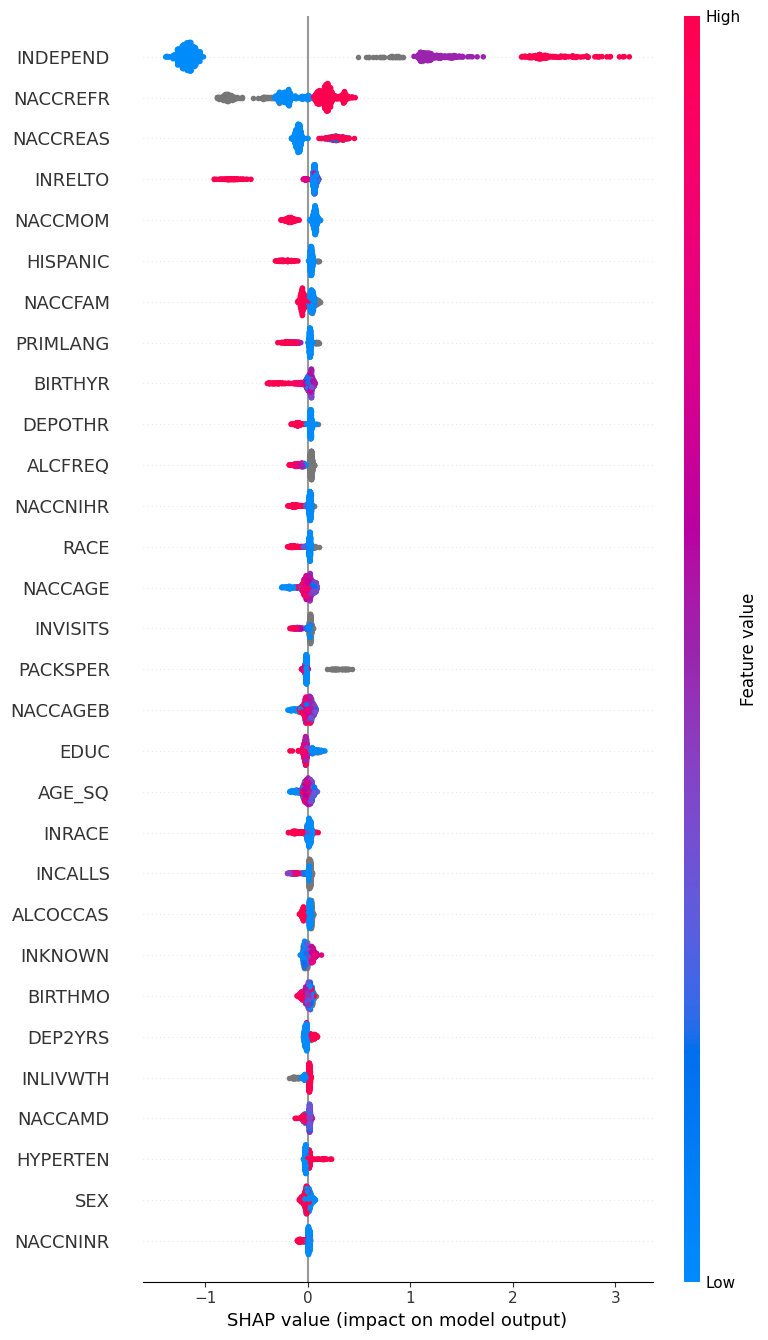

In [61]:
import shap

shap.initjs()

# 7. SHAP explanations for global and local understanding
explainer = shap.TreeExplainer(final_cat)
shap_values = explainer.shap_values(X_test)

# Global summary: which features and what directions
shap.summary_plot(shap_values, X_test, max_display=30)

# Individual patient explanation (e.g., first row in test set)
idx = 0
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_test.iloc[idx, :])

## What the model found.

#### So what did the model actually find ?

## What the model found

#### Loss of independence is the strongest signal of dementia risk

* The most important feature in the model is **INDEPEND**, which measures how much help a person needs with everyday activities.
* Participants who are fully independent are consistently assigned low risk scores, while those who need help with many tasks or who are fully dependent are pushed strongly toward the "dementia" side of the prediction.
* In practical terms, functional decline—without any formal cognitive tests—is the single clearest non-medical marker the model uses.

#### How and why a person enters the clinic carries important information

* **NACCREFR** (referral source) and **NACCREAS** (reason for visit) are among the top features.
* Being referred by a health-care professional, or coming mainly for a clinical evaluation rather than purely for research, is associated with higher predicted dementia risk.
* The model has effectively learned that when clinicians are concerned enough to refer someone, dementia is more likely.

#### Age is a strong risk factor with a non-linear effect

* Age-related variables such as **BIRTHYR**, **NACCAGE**, **NACCAGEB**, and the engineered **AGE_SQ** term work together to capture the effect of age.
* As expected, higher age increases the predicted probability of dementia.
* The presence of **AGE_SQ** indicates that this effect is not perfectly linear; risk accelerates at older ages rather than increasing at a constant rate.

#### Family history of cognitive problems raises risk

* **NACCFAM** (any family history of cognitive impairment) and **NACCMOM** (mother with cognitive impairment) both appear near the top of the importance ranking.
* When close relatives have had memory or thinking problems, the model shifts predictions toward higher risk for the participant, consistent with known genetic and familial contributions to dementia.

#### Demographic and language background provide smaller, fine-tuning signals

* Variables such as **HISPANIC**, **NACCNIHR** (race category), **INRACE**, **SEX/INSEX**, **BIRTHMO**, **HANDED**, and **PRIMLANG** (primary language) all contribute, but with more modest effect sizes.
* These features help the model fine-tune risk estimates and likely reflect a combination of true epidemiologic differences and differences in who gets referred and evaluated in practice.

#### Lifestyle and exposure history meaningfully affect risk

* Smoking-related features, especially **PACKSPER** (packs per day) and the engineered **PACK_YEARS** (lifetime smoking exposure), are important predictors. Heavier and longer smoking histories are associated with higher dementia risk.
* Alcohol variables **ALCOCCAS** and **ALCFREQ** also influence predictions: more frequent or heavier alcohol use nudges risk upward, although their impact is smaller than independence, age, or family history.

#### Overall health and medication burden act as proxies for vulnerability

* **NACCAMD** (any routine medications) appears as a notable feature.
* A higher medication burden is associated with higher dementia risk, likely because it reflects more complex or chronic medical conditions rather than any single medication effect.
* The model is using this as a general indicator of overall health status and frailty.

#### Psychiatric history is an important component of risk

* Features such as **DEPOTHR** (history of depression), **ANXIETY**, and the engineered **PSYCH_COUNT** (number of psychiatric conditions) all increase predicted risk when present.
* The model has learned that people with more psychiatric comorbidity are more likely to be classified as demented, which is consistent with the close relationship between mood/behavioral changes and cognitive decline.

#### Neurologic diagnoses like Parkinson’s disease are strong red flags

* **PD** (Parkinson’s disease) is one of the more influential medical history variables.
* When Parkinson’s disease is present, the model shifts predictions toward higher dementia risk, aligning with clinical knowledge that Parkinsonian disorders often involve or progress to cognitive impairment.

#### Informant characteristics add subtle but useful context

* Variables describing the informant, such as **INRELTO** (relationship to the participant), **INKNOWN** (how well the informant knows the participant), and contact frequency measures (e.g., **INVISITS**, **INCALLS**), provide smaller but still meaningful contributions.
* These features likely help the model judge how reliable and close the informant is, which indirectly reflects how obvious or severe the participant’s functional and cognitive changes might be.

---

#### Overall summary

Using only non-medical and self-reported information, the model has learned a clinically plausible pattern: people who are older, less independent, referred for clinical concerns, with a family history of cognitive problems, higher smoking exposure, psychiatric history, and neurologic diagnoses such as Parkinson’s disease are predicted to be at higher risk of dementia.
